In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


print("Running...")


thr_std=0.2


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [38]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx


In [3]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [4]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [5]:
def phi_hist(plane, event_number, thresholding=True, no_std=thr_std, leastz=False, centre_coord=(0,0), no_sectors=20, centre=0, printhist=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score

In [6]:
def rfunc(r):
    return 1/(r+1)



def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=20, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    

    return norm_score

In [39]:
def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in tqdm(range(no_points)):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]


In [72]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = [] #avoid appends to lists; if you know how long the outputs are going to be, then assign the arrays to
                    #that length beforehand
    
    for i in tqdm(range(no_events)):
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
        Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
        Zvert.append(Zvert_place)
        Xvert.append(Xvert_place)
        Zvert_true.append(Zvert_true_place)
        Xvert_true.append(Xvert_true_place)
    
    '''
    print(Zvert_true)
    print(Zvert)
    print(Xvert_true)
    print(Xvert)
    '''
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2

    print(len(delta_r2))
    print(delta_r2)
    
    #data, bins = np.histogram(delta_r2)
    #delta_r2 = delta_r2[delta_r2 < 0.4e6]
    delta_r2 = np.sqrt(delta_r2)
    plt.hist(delta_r2, bins='auto')
    #plt.ylim(0, 400)
    plt.show()

    return delta_r2, np.percentile(delta_r2, 68)

100%|██████████████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 5096.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 859/859 [00:00<00:00, 4422.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 5539.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5512.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3000.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2001.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 363/363 [00:00<00:00, 5290.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 852/852 [00:00<00:00, 4389.35it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 5410.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3335.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3333.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 531/531 [00:00<00:00, 3511.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 407/407 [00:00<00:00, 3362.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 561/561 [00:00<00:00, 4503.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 4667.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3750.16it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 5643.74it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:00<00:00, 4540.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 4739.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 4750.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 5348.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 5446.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 5120.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 4976.29it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 652/652 [00:00<00:00, 4670.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 4710.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5319.87it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:00<00:00, 3935.14it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1366/1366 [00:00<00:00, 3621.50it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1443/1443 [00:00<00:00, 4212.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 5146.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 4498.72it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 3386/3386 [00:01<00:00, 2778.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 5252.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 5339.68it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 4278.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 5067.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 5497.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 4886.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 5536.70it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 449/449 [00:00<00:00, 5538.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [00:00<00:00, 5087.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 4859.81it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1103/1103 [00:00<00:00, 4541.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 5460.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 5464.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 5113.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 3898.24it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 5672.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 784/784 [00:00<00:00, 5031.94it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2470/2470 [00:00<00:00, 3457.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 4853.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 5335.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 5306.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 5454.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 3494.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 4882.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 5687.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 5746.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 5242.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 5402.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 5719.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 4831.15it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1111/1111 [00:00<00:00, 4546.11it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 5493.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 4856.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 4872.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 510/510 [00:00<00:00, 5333.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 5641.25it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 4793.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 5100.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 5368.07it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1282/1282 [00:00<00:00, 4289.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 5490.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 348/348 [00:00<00:00, 5558.18it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1094/1094 [00:00<00:00, 4478.63it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1752/1752 [00:00<00:00, 3880.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 5694.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 5752.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 5679.57it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 5544.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 5236.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 5225.41it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 4399.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4653.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 5259.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 5200.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 5275.77it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 5264.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 5376.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 5249.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 4652.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 5100.98it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1711/1711 [00:00<00:00, 3730.47it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1711/1711 [00:00<00:00, 3691.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 5596.32it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 5026.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 516/516 [00:00<00:00, 5456.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 5563.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 391/391 [00:00<00:00, 5534.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 795/795 [00:00<00:00, 4857.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 5054.05it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1919/1919 [00:00<00:00, 3738.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 4770.19it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1885/1885 [00:00<00:00, 4133.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 372/372 [00:00<00:00, 5584.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 5623.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 5231.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 5231.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 488/488 [00:00<00:00, 5449.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3751.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 4999.97it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 5243.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 5637.53it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1971/1971 [00:00<00:00, 3550.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1997.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2000.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 5223.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 5520.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 5529.81it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 5535.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 363/363 [00:00<00:00, 5535.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 5678.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 5325.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 5494.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 593/593 [00:00<00:00, 5040.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 672/672 [00:00<00:00, 5046.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 5641.57it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 851/851 [00:00<00:00, 4816.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 3665.67it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1370/1370 [00:00<00:00, 3177.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 5340.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 5200.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 463/463 [00:00<00:00, 4114.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 3998.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 5000.42it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 3748.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 5315.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 4543.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 719/719 [00:00<00:00, 4301.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 4707.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 4758.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 419/419 [00:00<00:00, 4669.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 494/494 [00:00<00:00, 4457.27it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 4952.41it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2766/2766 [00:01<00:00, 2631.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 4376.78it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1372/1372 [00:00<00:00, 3454.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 518/518 [00:00<00:00, 3820.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 4481.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 5386.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 5348.94it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 4842.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 4933.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 4995.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 5168.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 4982.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 856/856 [00:00<00:00, 4395.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 4597.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 4840.08it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:00<00:00, 4043.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 427/427 [00:00<00:00, 4844.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 5090.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 5149.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 4952.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 5300.48it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:00<00:00, 3693.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 5064.07it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 5127.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 4596.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 5423.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 4254.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 4789.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 4764.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 541/541 [00:00<00:00, 4530.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 4474.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 4609.26it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1422/1422 [00:00<00:00, 3656.34it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1422/1422 [00:00<00:00, 3613.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 4856.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 537/537 [00:00<00:00, 4660.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 470/470 [00:00<00:00, 5018.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 4820.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 4798.29it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 4368.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 4885.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 4121.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 5081.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 4910.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 4883.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5009.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2500.48it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 5205.14it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1435/1435 [00:00<00:00, 3718.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 4948.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 4950.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3110.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 4750.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 4939.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 5302.88it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 5391.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 5490.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 5445.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 898/898 [00:00<00:00, 4391.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 535/535 [00:00<00:00, 4652.15it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1180/1180 [00:00<00:00, 3378.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 5132.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 5093.61it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 5264.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 4786.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 4945.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 4805.57it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:00<00:00, 3675.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2998.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3093.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 5514.45it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 5051.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 5136.76it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1699/1699 [00:00<00:00, 3644.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 4629.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 4617.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 4912.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 535/535 [00:00<00:00, 4667.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 5169.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 4857.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 4882.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 715/715 [00:00<00:00, 4487.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 5115.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 5096.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 5252.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 586/586 [00:00<00:00, 4475.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 5012.54it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1253/1253 [00:00<00:00, 3949.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 472/472 [00:00<00:00, 4815.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 703/703 [00:00<00:00, 4452.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 5113.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 5275.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 5196.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 5199.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 5079.69it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 5065.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 5803.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 4827.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 4291.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 4525.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 3633.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 4934.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 5234.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 5086.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 4644.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 435/435 [00:00<00:00, 4575.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 435/435 [00:00<00:00, 4170.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 4863.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 4583.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 4570.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 5392.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 4285.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 4041.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 4949.70it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1752/1752 [00:00<00:00, 3434.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 4051.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 4681.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 4515.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 671/671 [00:00<00:00, 4211.51it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 3689.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 4937.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 5141.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 5081.22it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2379/2379 [00:00<00:00, 2557.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 483/483 [00:00<00:00, 5015.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 4871.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 2211.81it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████| 1088/1088 [00:00<00:00, 4054.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 4545.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 4935.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 4924.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 4617.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 4281.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 5003.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 578/578 [00:00<00:00, 4820.64it/s]

100%|███████████████████████████

1000
[1.79006494e+03 1.83862451e+03 9.02003516e+04 4.42273877e+03
 8.90091515e+00 1.68575821e+02 7.59267285e+03 6.27265310e+00
 1.55451270e+04 1.48113721e+03 6.96005312e+05 7.94704723e+00
 5.68000732e+02 1.93050671e+03 7.58938551e-01 5.36772583e+02
 5.27725312e+05 9.33897461e+03 1.08787422e+05 1.97207520e+03
 8.43001633e+01 9.54181797e+04 2.25601555e-03 6.34864922e+04
 1.45583328e+05 6.14005518e+03 6.91054985e-02 6.96201233e+02
 7.47116500e+05 8.02199268e+03 6.33455688e+02 1.79278711e+03
 8.37614670e+01 6.77052051e+03 5.75969582e+01 1.02957910e+04
 2.70382324e+03 1.85668964e+01 3.78936562e+04 2.49301221e+03
 4.57192192e+01 5.55683579e-03 6.88224750e+05 7.80391641e+04
 1.12040043e+01 2.85418594e+05 6.17309229e+03 8.48406677e+01
 2.63839102e+04 1.42863354e+03 3.71008047e+04 3.83987378e+03
 5.13933398e+03 8.73381042e+02 2.03339813e+02 2.90444794e+01
 4.55476318e+03 2.62370312e+04 2.68032520e+04 3.77949938e+05
 9.80541797e+03 1.53270447e+02 4.55525786e-01 4.36880127e+03
 9.20097656e+03 1.2

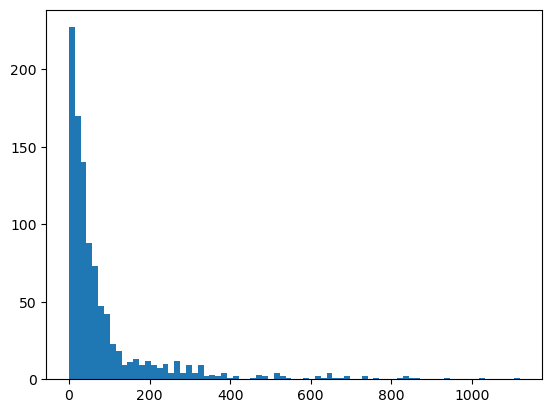

In [73]:
datadata = accuracy("v", optimise_phi, 1000)

In [74]:
print(np.percentile(datadata, 68))

69.0364373779297
